In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

from sklearn.preprocessing import PolynomialFeatures
from sm_diagnostics import LinearRegDiagnostic


sns.set_theme(style='whitegrid', font='Franklin Gothic Book')
WIDE = (5*1.618, 5)
SQUARE = (5, 5)

In [53]:
data = pd.read_csv('data/2024_07/all_time_women_all_events.csv')

In [54]:
def convert_to_meters(row: str) -> int:
    try:
        distance = int(row.replace('m', ''))
    except:
        match row:
            case 'mile': distance = 1609
            case '2mile': distance = 3218
            case 'halfMarathon': distance = 21097
            case 'marathon': distance = 42195

    return distance

In [55]:
data['distance_meters'] = data['event'].apply(convert_to_meters)
# data['distance_meters'].unique()

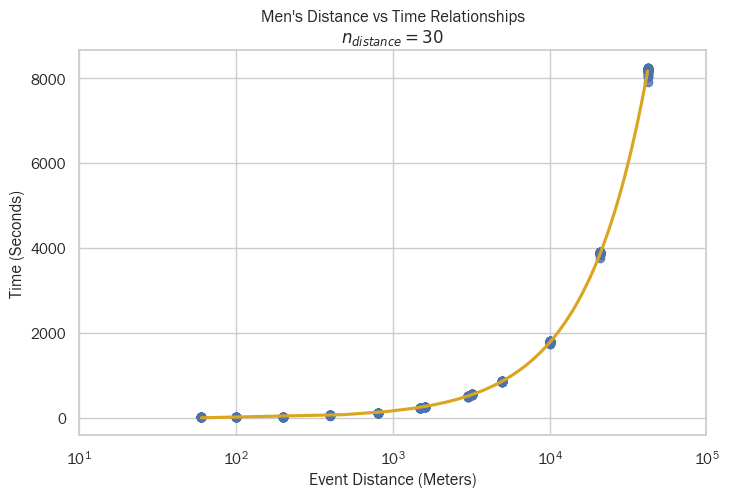

In [56]:
plot_data = data.sort_values(['distance_meters', 'Mark_Seconds']).groupby('event').head(30)

plt.figure(figsize=WIDE)
# plt.scatter(plot_data['distance_meters'], plot_data['Mark_Seconds'])
sns.regplot(data=plot_data,
            x='distance_meters',
            y='Mark_Seconds',
            # lowess=True,
            order=3,
            line_kws={'color': 'goldenrod'})
plt.xscale('log')
plt.xticks(np.geomspace(10, 100000, 5, endpoint=True))
plt.title("Men's Distance vs Time Relationships\n$n_{distance} = 30$")
plt.ylabel('Time (Seconds)')
plt.xlabel('Event Distance (Meters)')

plt.show()

### Power Law, according to Riegel (1981)

In [67]:
def plot_power_law(data):
    data['log_x'] = np.log(data['distance_meters'])
    data['log_y'] = np.log(data['Mark_Seconds'])
    
    plt.figure(figsize=SQUARE)
    sns.regplot(data=data,
                x='log_x',
                y='log_y',
                line_kws={'color': 'goldenrod'})
    plt.show()

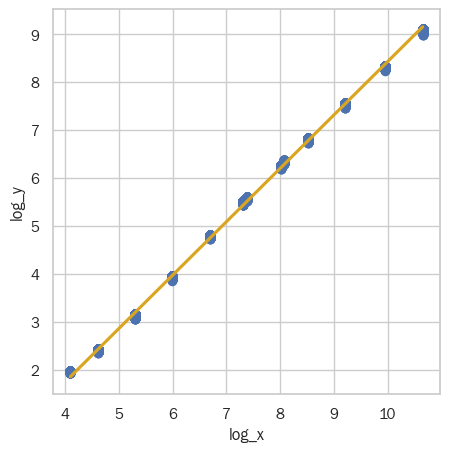

In [68]:
plot_power_law(data=data)

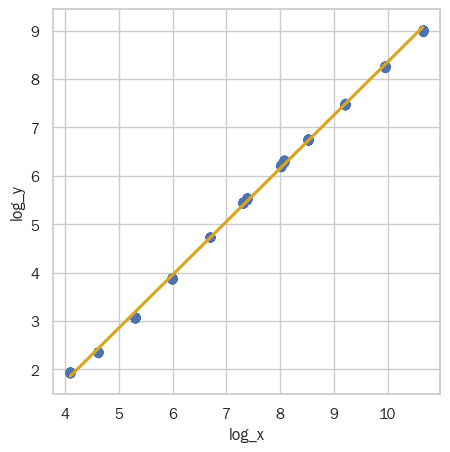

In [69]:
plot_power_law(data=plot_data)

In [60]:
X = sm.add_constant(np.log(plot_data['distance_meters']))
Y = np.log(plot_data['Mark_Seconds'])

womens_rlm = sm.RLM(Y, X, M=sm.robust.norms.HuberT()).fit()
womens_rlm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           Mark_Seconds   No. Observations:                  390
Model:                            RLM   Df Residuals:                      388
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 23 Jul 2024                                         
Time:                        13:34:24                                         
No. Iterations:                     8                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.6344      0.013   -207.058      0.000      -2.659      -2.609
distance_meters     1.0990      0.002    657.814      0.000       1.096       1.102
===================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [61]:
womens_lm = sm.OLS(Y, X).fit()
womens_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Mark_Seconds   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.680e+05
Date:                Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:34:24   Log-Likelihood:                 538.17
No. Observations:                 390   AIC:                            -1072.
Df Residuals:                     388   BIC:                            -1064.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.6358      0.012   -215.409      0.000      -2.660      -2.612
distance_meters     1.0992      0.002    684.080      0.000       1.096       1.102
==============================================================================
Omnibus:                      298.174   Durbin-Watson:                   0.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.955
Skew:                          -0.378   Prob(JB):                     4.23e-08
Kurtosis:                       1.767   Cond. No.                         30.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

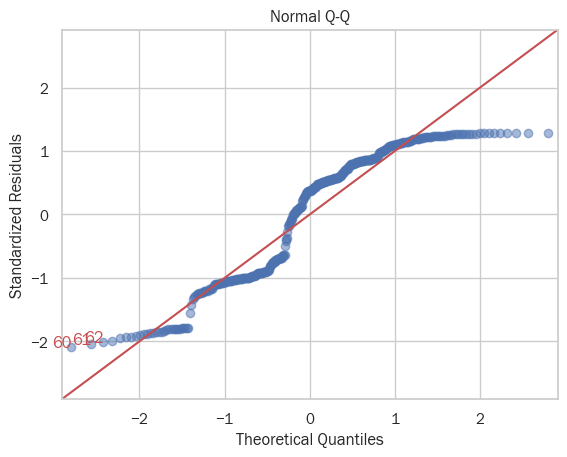

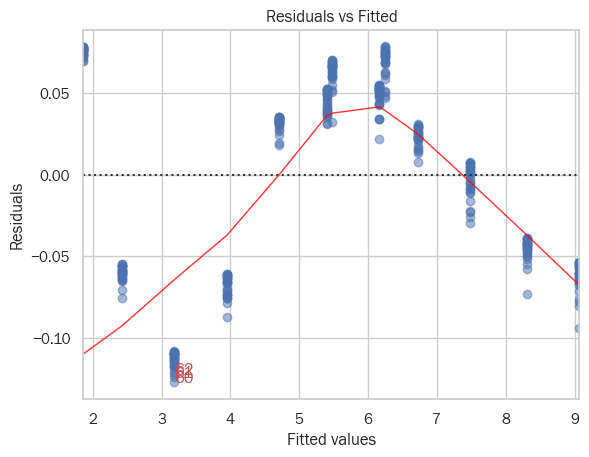

In [62]:
riegler = LinearRegDiagnostic(womens_lm)

riegler.qq_plot()
plt.show()

riegler.residual_plot()
plt.show()

### Quadratic Model

In [63]:
X = PolynomialFeatures(degree=2).fit_transform(plot_data[['distance_meters']])
Y = plot_data['Mark_Seconds']

sm.OLS(Y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Mark_Seconds   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.654e+06
Date:                Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:34:25   Log-Likelihood:                -1797.5
No. Observations:                 390   AIC:                             3601.
Df Residuals:                     387   BIC:                             3613.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.8871      1.662    -11.969      0.000     -23.154     -16.620
x1             0.1749      0.000    443.969      0.000       0.174       0.176
x2          4.524e-07   9.64e-09     46.914      0.000    4.33e-07    4.71e-07
==============================================================================
Omnibus:                      371.575   Durbin-Watson:                   0.530
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22108.298
Skew:                          -3.770   Prob(JB):                         0.00
Kurtosis:                      39.106   Cond. No.                     6.86e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.86e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

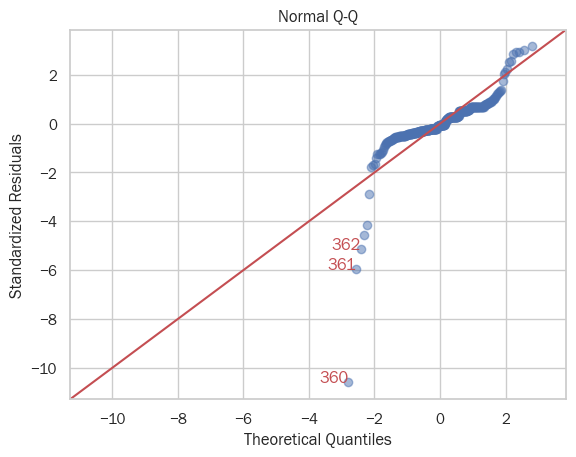

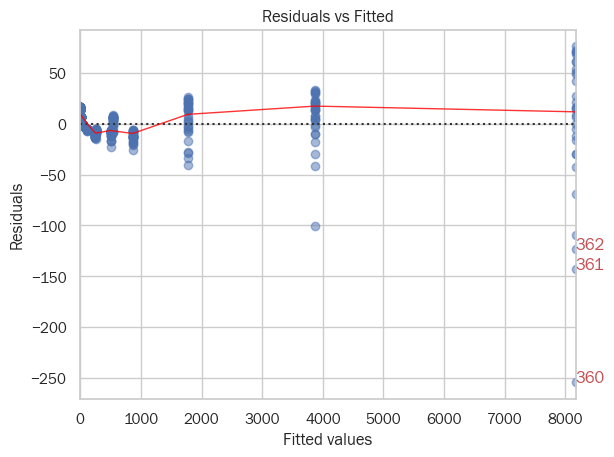

In [64]:
poly = LinearRegDiagnostic(sm.OLS(Y, X).fit())

poly.qq_plot()
plt.show()

poly.residual_plot()
plt.show()

In [65]:
X = PolynomialFeatures(degree=3).fit_transform(plot_data[['distance_meters']])
Y = plot_data['Mark_Seconds']

sm.OLS(Y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Mark_Seconds   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.138e+06
Date:                Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:34:26   Log-Likelihood:                -1790.9
No. Observations:                 390   AIC:                             3590.
Df Residuals:                     386   BIC:                             3606.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.1034      1.940     -8.300      0.000     -19.918     -12.289
x1             0.1718      0.001    179.094      0.000       0.170       0.174
x2          7.074e-07   7.09e-08      9.971      0.000    5.68e-07    8.47e-07
x3         -4.332e-12   1.19e-12     -3.627      0.000   -6.68e-12   -1.98e-12
==============================================================================
Omnibus:                      378.558   Durbin-Watson:                   0.538
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24447.123
Skew:                          -3.857   Prob(JB):                         0.00
Kurtosis:                      41.012   Cond. No.                     3.35e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.35e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

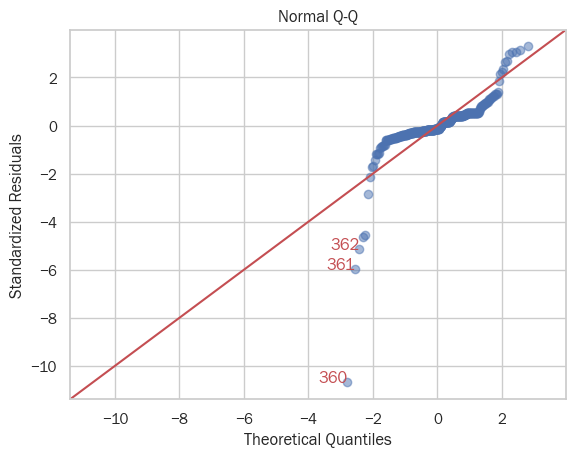

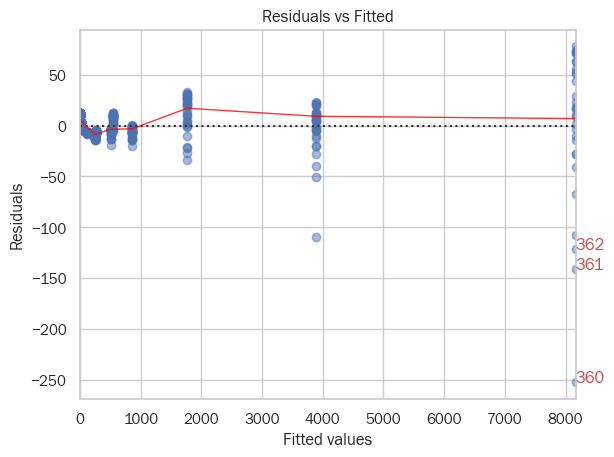

In [66]:
poly = LinearRegDiagnostic(sm.OLS(Y, X).fit())

poly.qq_plot()
plt.show()

poly.residual_plot()
plt.show()